In [2]:
!pip install -q -U keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.1 MB/s eta 0:00:00


In [5]:
!unzip train_merged.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: train_merged/Sample057/img057-00156.png  
  inflating: train_merged/Sample057/img057-00157.png  
  inflating: train_merged/Sample057/img057-00158.png  
  inflating: train_merged/Sample057/img057-00159.png  
  inflating: train_merged/Sample057/img057-00160.png  
  inflating: train_merged/Sample057/img057-00161.png  
  inflating: train_merged/Sample057/img057-00162.png  
  inflating: train_merged/Sample057/img057-00163.png  
  inflating: train_merged/Sample057/img057-00164.png  
  inflating: train_merged/Sample057/img057-00165.png  
  inflating: train_merged/Sample057/img057-00166.png  
  inflating: train_merged/Sample057/img057-00167.png  
  inflating: train_merged/Sample057/img057-00168.png  
  inflating: train_merged/Sample057/img057-00169.png  
  inflating: train_merged/Sample057/img057-00170.png  
  inflating: train_merged/Sample057/img057-00171.png  
  inflating: train_merged/Sample057/img057-00172.png  
  inflating: t

In [37]:
import numpy as np
import os
import cv2  # OpenCV a képek beolvasásához
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import keras_tuner as kt


In [6]:
# Create a mapping dictionary (confusion matrix-nak kell, mert amúgy csak 0-61-ig írná ki a számokat)
label_to_char = {}

# Map labels 0-9 to characters '0'-'9'
for i in range(10):
    label_to_char[i] = str(i)

# Map labels 10-35 to characters 'A'-'Z'
for i in range(10, 36):
    label_to_char[i] = chr(i + 55)  # ASCII 'A' is 65, so 10 + 55 = 65

# Map labels 36-61 to characters 'a'-'z'
for i in range(36, 62):
    label_to_char[i] = chr(i + 61)  # ASCII 'a' is 97, so 36 + 61 = 97

# Print the mapping
# for label, char in label_to_char.items():
#     print(f"{label}: '{char}'")

In [7]:
# Csak gpu-s futtatáshoz (főleg nekem :), neked nem, nincs NVIDIA videókártyád)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

len(gpus)

1

In [8]:
# alapból 128x128
# ezt használja a dataset betöltés itt lent
# illetve a modell is innen kapja meg a képek méretét
img_size = (64,64)
# azt figyeltem meg, hogy nem nagyon ront az eredményen, ha 128 helyett csak 64-et használunk

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'train_merged', image_size=img_size, batch_size=64,
    seed = 30,
    validation_split = 0.2, subset = 'both',
    label_mode = 'int',
    color_mode ='grayscale'
)

Found 53172 files belonging to 62 classes.
Using 42538 files for training.
Using 10634 files for validation.


In [10]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [11]:
train = dataset[0]
validate  = dataset[1]
train = train.map(normalize)
validate = validate.map(normalize)

num_classes = np.unique(dataset[0].class_names).shape[0]

In [45]:
def get_model():
    model = Sequential()

    # Első konvolúciós réteg
    model.add(Conv2D(32, (3, 3), padding='valid', input_shape=(img_size[0],img_size[1], 1)))  # 32 szűrő, 3x3 kernel
    model.add(Activation('relu'))  # ReLU aktiváció

    # Második konvolúciós réteg
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2 méretű pooling réteg
    model.add(Dropout(0.3))  # Dropout a túlillesztés elkerülése érdekében

    # Harmadik konvolúciós réteg
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    # Negyedik konvolúciós réteg
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    # Adatok lapítása, hogy sűrű rétegbe kerüljenek
    model.add(Flatten())

    # Sűrű réteg 512 neuronnal
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))  # Dropout a túlillesztés elkerülése érdekében

    # Kimeneti réteg 62 neuronnal (osztályok száma)
    model.add(Dense(62))
    model.add(Activation('softmax'))  # Softmax aktiváció az osztályozáshoz

    return model


# Cross-val

In [31]:
# dataset -> numpy array (mert nem valami könnyen indexelhető ez a dataset object)
features_np = []
labels_np = []

for feature_batch, label_batch in train.as_numpy_iterator():
    features_np.append(feature_batch)
    labels_np.append(label_batch)

In [32]:
# Concatenate the lists into NumPy arrays
features_np = np.concatenate(features_np, axis=0)
labels_np = np.concatenate(labels_np, axis=0)

In [39]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # A validációs veszteséget figyeli
    factor=0.5,          # A tanulási ráta felére csökkentése
    patience=2,          # 2 epoch után csökkenti, ha nincs javulás
    min_lr=1e-6          # Minimális tanulási ráta
)
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [74]:
histories = []
incorrect_predictions = []

for train_idx, test_idx in kfold.split(features_np, labels_np):
    tf.keras.backend.clear_session()  # Clear previous session

    X_train_fold = features_np[train_idx]
    y_train_fold = labels_np[train_idx]
    X_test_fold = features_np[test_idx]
    y_test_fold = labels_np[test_idx]

    print(X_train_fold.shape)
    print(y_train_fold.shape)
    print(X_test_fold.shape)
    print(y_test_fold.shape)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold)).batch(64)
    val_dataset = tf.data.Dataset.from_tensor_slices((X_test_fold, y_test_fold)).batch(64)


    model = get_model()


    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


    history = model.fit(train_dataset, batch_size=64, epochs=6,
                        callbacks=[reduce_lr], verbose=1, validation_data=val_dataset)

    histories.append(history)

    y_pred = model.predict(val_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Helytelen predikciók indexeinek kinyerése
    incorrect_indices = np.where(y_pred_classes != y_test_fold)[0]

    # Mentjük a helytelen predikciókat a validációs halmazból
    for idx in incorrect_indices:
        incorrect_predictions.append({
            "fold": len(histories),  # Melyik fold
            "true_label": y_test_fold[idx],
            "predicted_label": y_pred_classes[idx],
            "image": X_test_fold[idx]  # Az eredeti kép
        })

# Helytelen predikciók száma
print(f"Helytelen predikciók száma összesen: {len(incorrect_predictions)}")




(34030, 64, 64, 1)
(34030,)
(8508, 64, 64, 1)
(8508,)
Epoch 1/6


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


532/532 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.5349 - loss: 1.8165 - val_accuracy: 0.8344 - val_loss: 0.5065 - learning_rate: 0.0010
Epoch 2/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8334 - loss: 0.5002 - val_accuracy: 0.8674 - val_loss: 0.3723 - learning_rate: 0.0010
Epoch 3/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.8725 - loss: 0.3653 - val_accuracy: 0.8848 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 4/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.8880 - loss: 0.3003 - val_accuracy: 0.8890 - val_loss: 0.2882 - learning_rate: 0.0010
Epoch 5/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9013 - loss: 0.2611 - val_accuracy: 0.8984 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 6/6
532/532 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9099 - loss: 0.2343 - val_accuracy: 0.9039 - val_loss: 0.2550 - learning_rate: 0.0010
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
(34030, 64, 64, 1)
(34030,)
(8508, 64, 64, 1)
(8508,

In [1]:
# Initialize lists to hold accuracy values
train_accuracies = []
val_accuracies = []

# Iterate over each history in the histories list
for history in histories:
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])


NameError: name 'histories' is not defined

In [48]:
# Define a colormap for the number of folds
num_folds = len(histories)
colors = plt.cm.Accent(np.linspace(0, 1, num_folds))  # Use 'viridis' colormap


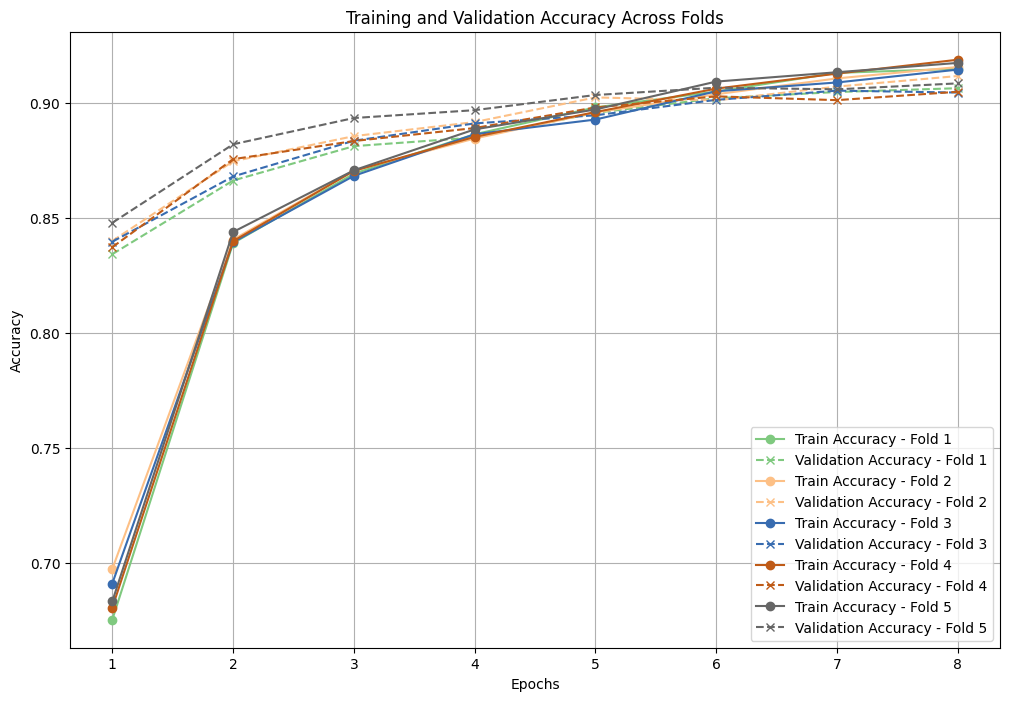

In [49]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Plot training and validation accuracy for each fold
for i in range(len(histories)):
    epochs = range(1, len(train_accuracies[i]) + 1)  # Get the range of epochs
    plt.plot(epochs, train_accuracies[i], label=f'Train Accuracy - Fold {i + 1}', linestyle='-', marker='o',color=colors[i])
    plt.plot(epochs, val_accuracies[i], label=f'Validation Accuracy - Fold {i + 1}', linestyle='--', marker='x',color=colors[i])

# Add titles and labels
plt.title('Training and Validation Accuracy Across Folds')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Show the plot
plt.show()


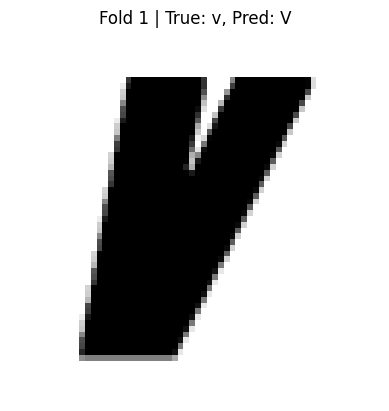

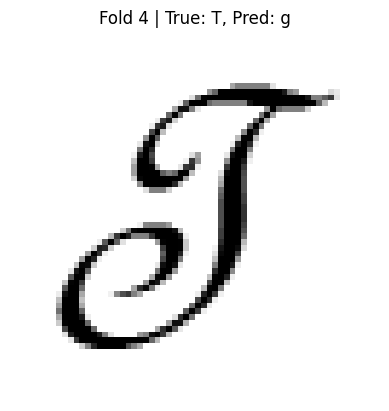

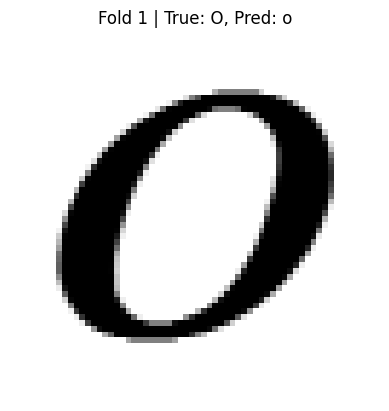

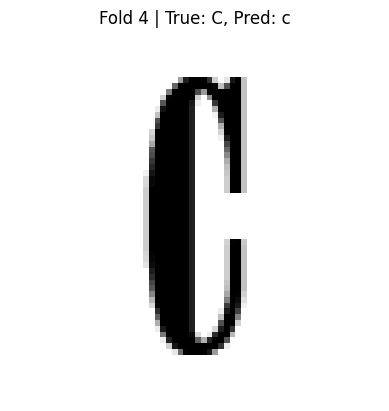

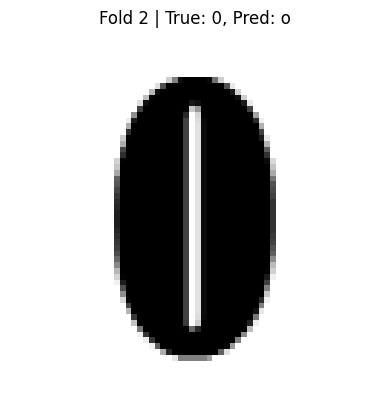

In [50]:
import random

# Véletlenszerűen válassz ki 5 helytelen predikciót
random_incorrect_samples = random.sample(incorrect_predictions, min(len(incorrect_predictions), 5))

# Megjelenítés
for incorrect in random_incorrect_samples:
    img = incorrect["image"]
    true_label = incorrect["true_label"]
    predicted_label = incorrect["predicted_label"]
    fold = incorrect["fold"]

    true_char = label_to_char[true_label]
    predicted_char = label_to_char[predicted_label]

    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Fold {fold} | True: {true_char}, Pred: {predicted_char}")
    plt.axis('off')
    plt.show()

# Tanítás validation-ön

In [51]:
model = get_model()

In [61]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [65]:
history = model.fit(train, validation_data = validate, epochs = 7, verbose=1)

Epoch 1/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.9050 - loss: 0.2476 - val_accuracy: 0.9067 - val_loss: 0.2544
Epoch 2/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9114 - loss: 0.2282 - val_accuracy: 0.9089 - val_loss: 0.2327
Epoch 3/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - accuracy: 0.9162 - loss: 0.2164 - val_accuracy: 0.9116 - val_loss: 0.2419
Epoch 4/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9226 - loss: 0.2043 - val_accuracy: 0.9146 - val_loss: 0.2238
Epoch 5/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.9245 - loss: 0.1989 - val_accuracy: 0.9127 - val_loss: 0.2382
Epoch 6/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.9244 - loss: 0.1955 - val_accuracy: 0.9134 - val_loss: 0.2264
Epoch 7/7
665/665 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step - accuracy: 0.9264 - loss: 0.1906 - val_accuracy: 0.9178 - val_loss: 0.2175


# Param optimizáció

In [ ]:
def build_model(hp):
    model = Sequential()

    # Hyperparameter for number of filters
    model.add(Conv2D(hp.Int('num_filters_1', min_value=32, max_value=128, step=32),
                     (3, 3),
                     padding='valid',
                     input_shape=(img_size[0], img_size[1], 1)))
    model.add(Activation('relu'))

    # Second Conv Layer
    model.add(Conv2D(hp.Int('num_filters_2', min_value=32, max_value=128, step=32), (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)))  # Dropout rate

    # Additional Conv Layers
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)))

    model.add(Flatten())

    # Dense Layer
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=64)))
    model.add(Activation('relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.2, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(62))
    model.add(Activation('softmax'))

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Initialize the random search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=1,  # How many times to evaluate each trial
    directory='my_dir',  # Directory to save the results
    project_name='random_search'
)

# Start the search
tuner.search(train_dataset, validation_data=val_dataset, epochs=10)  # Adjust epochs as needed


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best Hyperparameters:")
print(best_hyperparameters.values)


# Metrikák

In [66]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

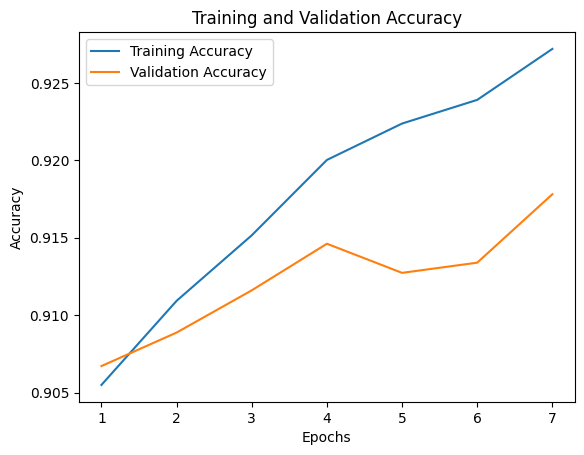

In [67]:
# Plot training & validation accuracy values
epochs = range(1, len(train_accuracy) + 1)

plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

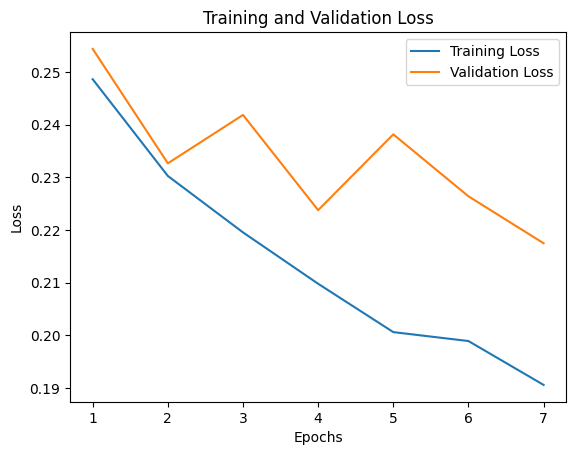

In [68]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [69]:
predictions = model.predict(validate)
predicted_labels = np.argmax(predictions, axis=1)

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


In [70]:
# Collect true labels from val_data
true_labels = np.concatenate([y.numpy() for x, y in validate], axis=0)

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [72]:
char_labels = [label_to_char[i] for i in range(62)]

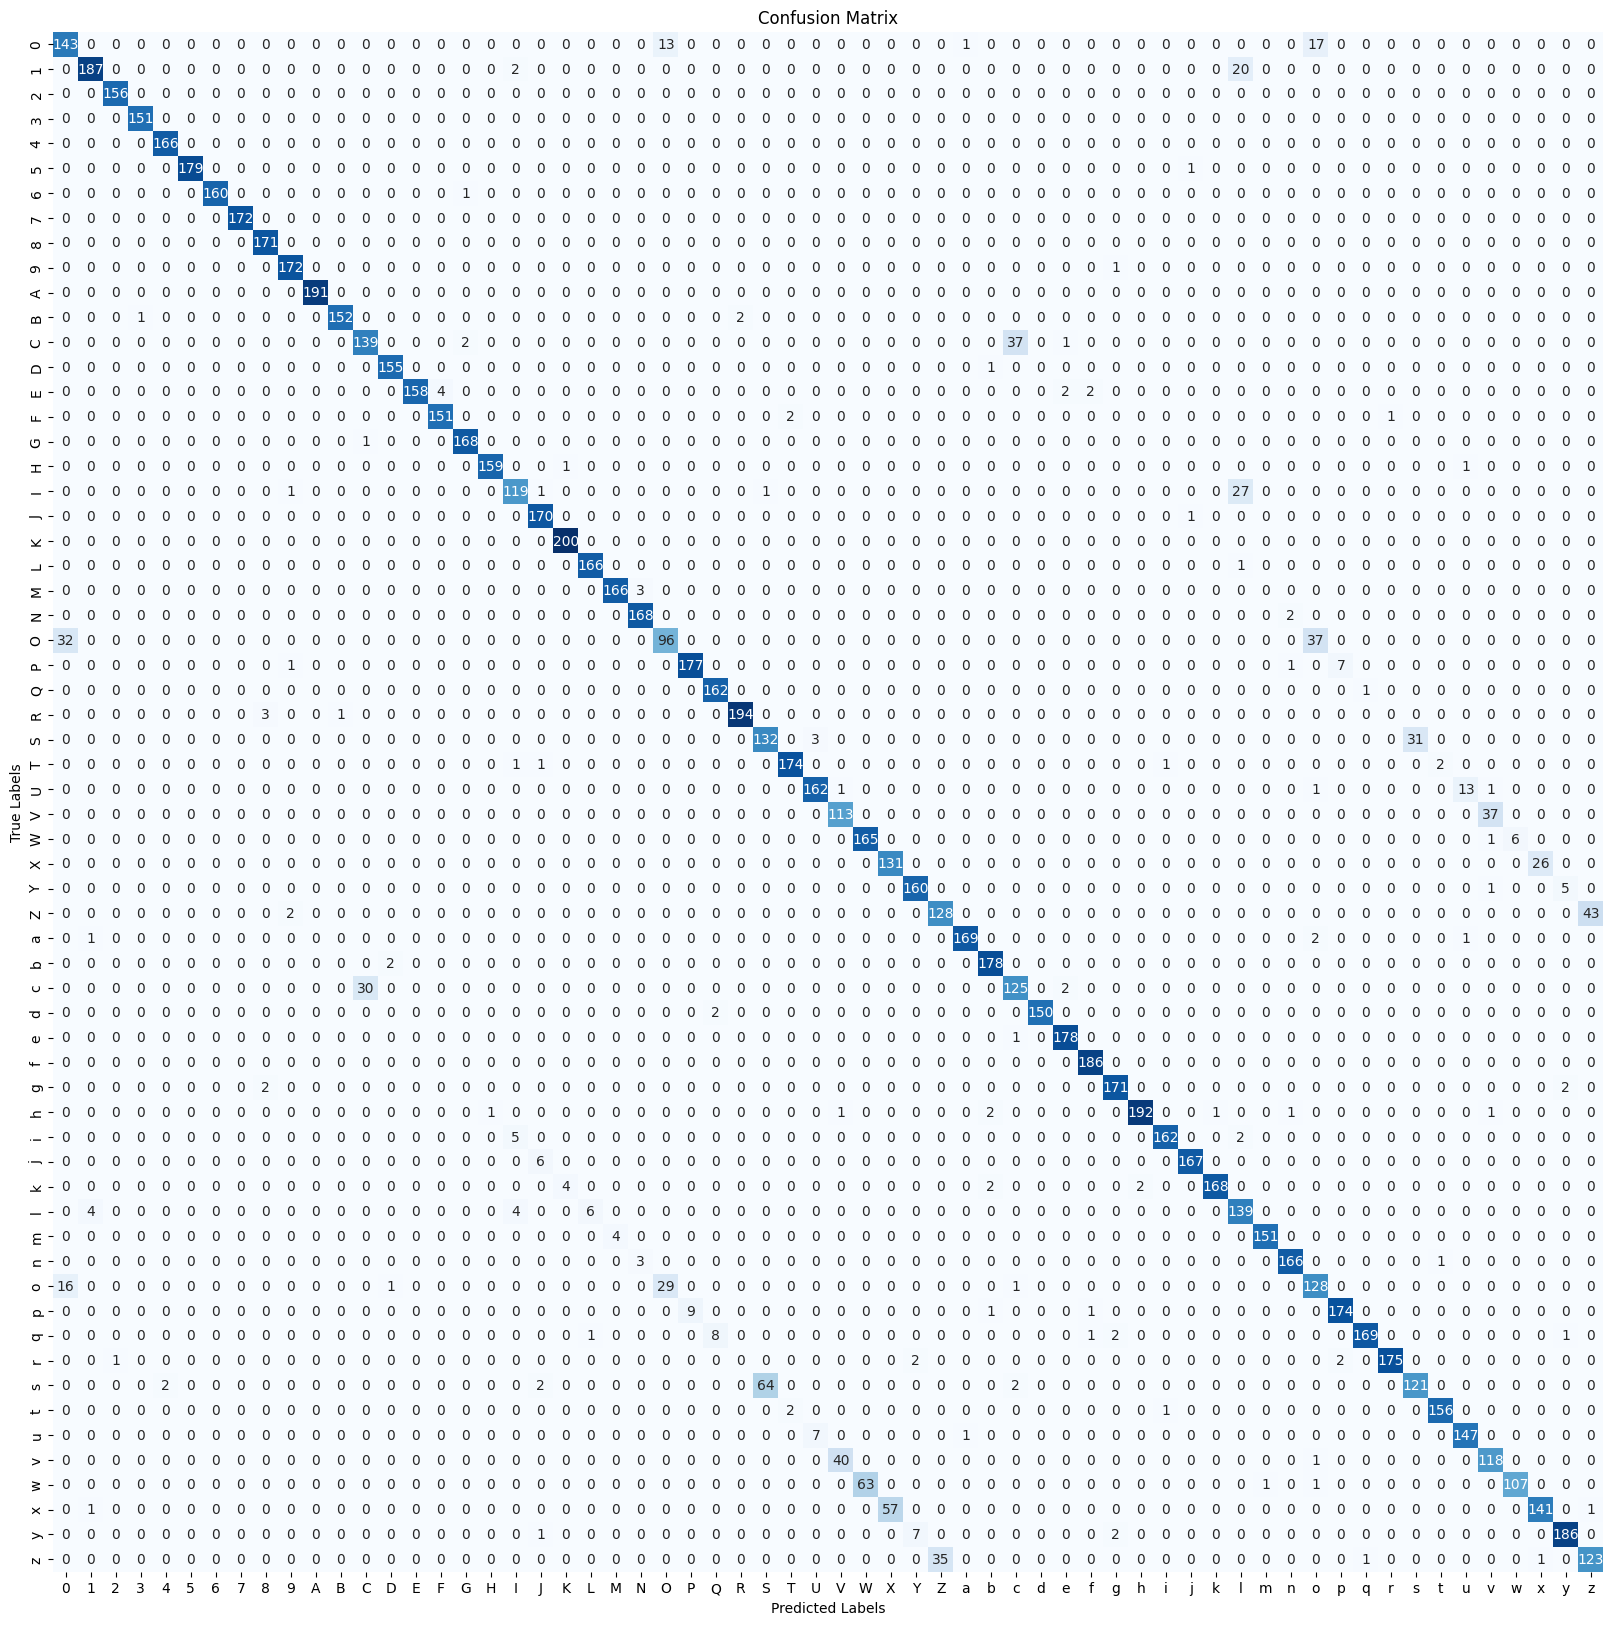

In [73]:
# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,xticklabels=char_labels, yticklabels=char_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

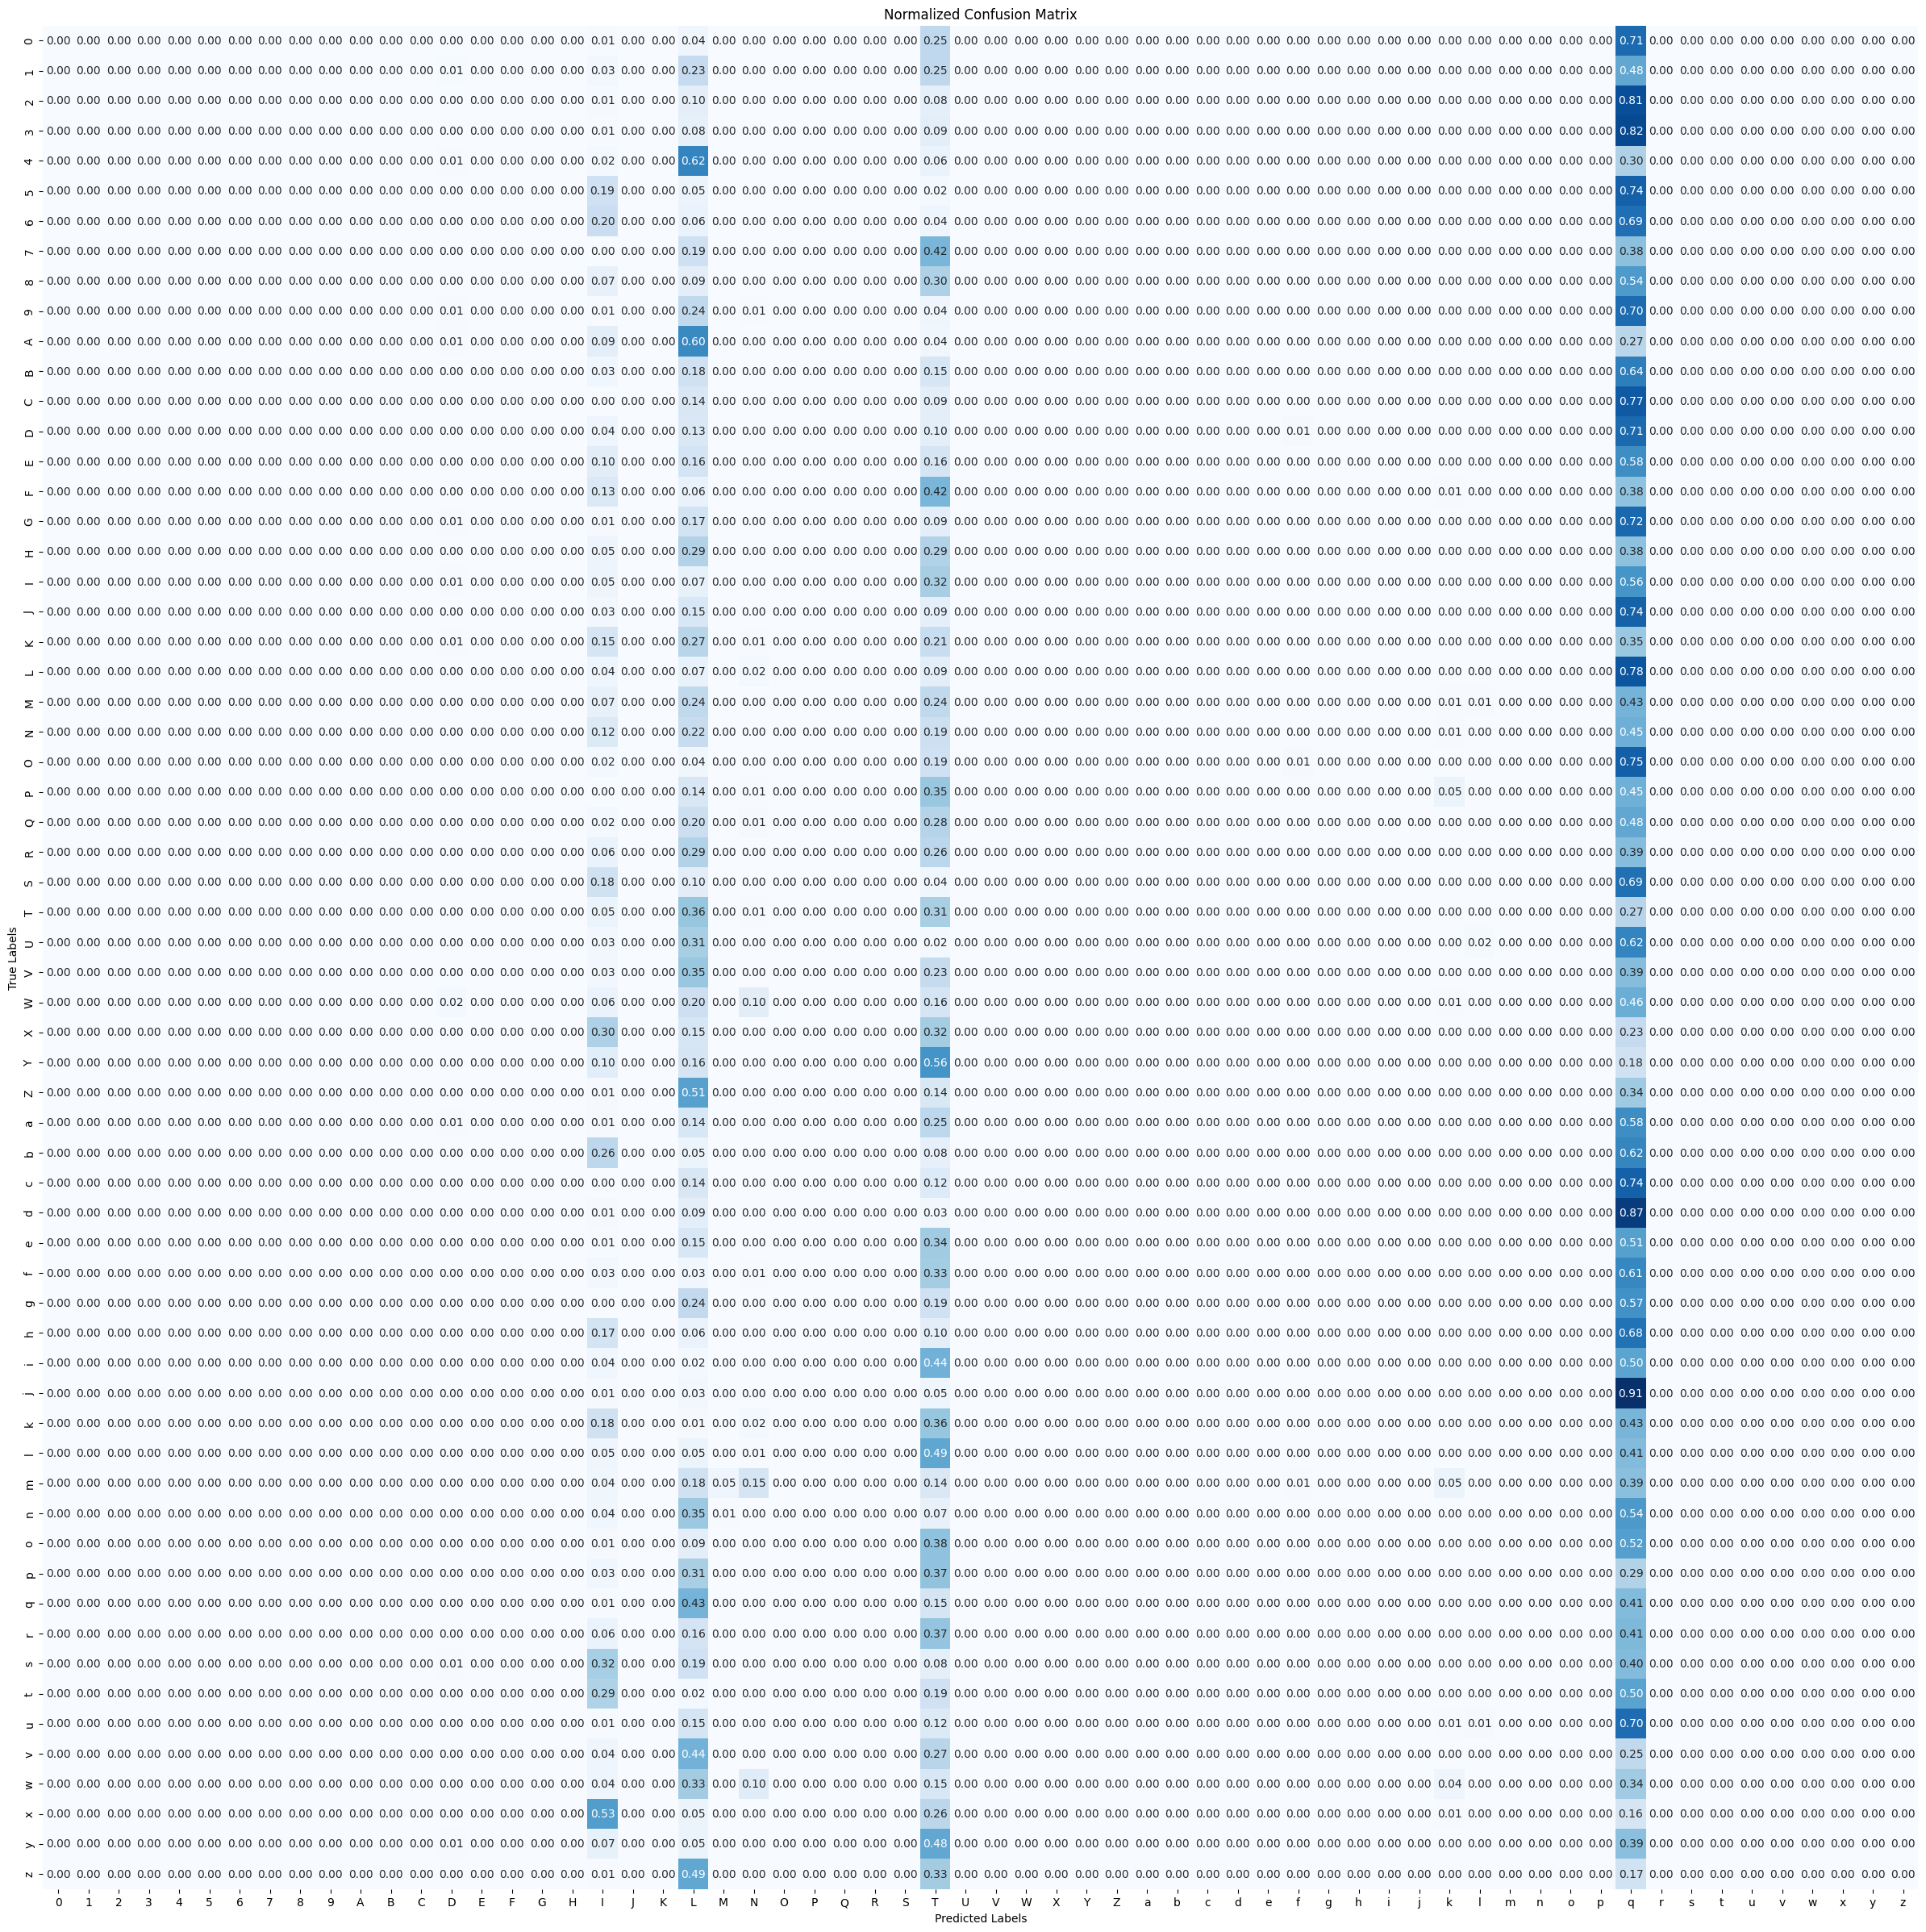

In [60]:
conf_matrix_normalized = conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(30, 30))
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=False,xticklabels=char_labels, yticklabels=char_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Confusion Matrix")
plt.show()

In [ ]:
def get_model_c():
    model = Sequential()

    # Első konvolúciós réteg
    model.add(Conv2D(64, (3, 3), padding='valid', input_shape=(img_size[0],img_size[1], 1)))  # 32 szűrő, 3x3 kernel
    model.add(BatchNormalization())
    model.add(Activation('relu'))  # ReLU aktiváció

    # Második konvolúciós réteg
    model.add(Conv2D(128, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))  # 2x2 méretű pooling réteg
    model.add(Dropout(0.3))  # Dropout a túlillesztés elkerülése érdekében

    # Harmadik konvolúciós réteg
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    # Negyedik konvolúciós réteg
    model.add(Conv2D(64, (3, 3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # Adatok lapítása, hogy sűrű rétegbe kerüljenek
    model.add(Flatten())

    # Sűrű réteg 512 neuronnal
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.4))  # Dropout a túlillesztés elkerülése érdekében

    # Kimeneti réteg 62 neuronnal (osztályok száma)
    model.add(Dense(62))
    model.add(Activation('softmax'))  # Softmax aktiváció az osztályozáshoz

    return model
